##### Copyright 2019 The TensorFlow Authors.

### Korean-English Translator with Transformer

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

##### Check GPU

In [1]:
!nvidia-smi

Wed Feb 17 10:18:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   43C    P0    50W / 300W |  29525MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   43C    P0    84W / 300W |   1774MiB / 32478MiB |     60%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

##### GPU Choice 

In [2]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

import os
#이 값으로 각자 사용할 GPU 선정
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
	try:
		tf.config.experimental.set_memory_growth(gpus[0], True)
	except RuntimeError as e:
		print(e)

#### Transformer model for language understanding

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial trains a <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer model</a> to translate Portuguese to English. This is an advanced example that assumes knowledge of [text generation](text_generation.ipynb) and [attention](nmt_with_attention.ipynb).

The core idea behind the Transformer model is *self-attention*—the ability to attend to different positions of the input sequence to compute a representation of that sequence. Transformer creates stacks of self-attention layers and is explained below in the sections *Scaled dot product attention* and *Multi-head attention*.

A transformer model handles variable-sized input using stacks of self-attention layers instead of [RNNs](text_classification_rnn.ipynb) or [CNNs](../images/intro_to_cnns.ipynb). This general architecture has a number of advantages:

* It make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8)).
* Layer outputs can be calculated in parallel, instead of a series like an RNN.
* Distant items can affect each other's output without passing through many RNN-steps, or convolution layers (see [Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf) for example).
* It can learn long-range dependencies. This is a challenge in many sequence tasks.

The downsides of this architecture are:

* For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.   
* If the input *does* have a  temporal/spatial relationship, like text, some positional encoding must be added or the model will effectively see a bag of words. 

In [3]:
# Pin matplotlib version to 3.2.2 since in the latest version
# transformer.ipynb fails with the following error:
# https://stackoverflow.com/questions/62953704/valueerror-the-number-of-fixedlocator-locations-5-usually-from-a-call-to-set
#!pip install -q matplotlib==3.2.2
#!pip install tensorflow_datasets

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

import time
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


##### Load Data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf

In [6]:
train_data = pd.read_csv('data_10만.csv')
train_data.head()

,원문,번역문
0,운동하기 위해 필요한 정보에요.,It is the information I need for a workout.
1,앞으로도 항상 이용해 주시기 바랍니다.,Hope to see you again next time.
2,노래방에서 스트레스를 풀 수 있었습니다.,I could relieve my stress while in a karaoke bar.
3,그 회사는 독성물질이 검출된 연구결과를 숨기고 이익을 위해 양심을 버리고 제품을 팔...,The results came as the company hid the findin...
4,내가 이해한 것이 맞는지 확인해 줄 수 있니?,Can you check if I have understood it right?


In [7]:
korean = []
for sentence in train_data['원문']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    korean.append(sentence)

In [8]:
english = []
for sentence in train_data['번역문']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    english.append(sentence)

Create a custom subwords tokenizer from the training dataset. 

In [9]:
tokenizer_ko = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    korean, target_vocab_size=2**16)
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    english, target_vocab_size=2**16)

In [10]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer_ko.vocab_size], [tokenizer_ko.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer_ko.vocab_size + 2

In [11]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('임의의 질문 샘플을 정수 인코딩 : {}'.format(tokenizer_ko.encode('내가 먹을 음식이 바로 이것입니다.')))

임의의 질문 샘플을 정수 인코딩 : [19, 414, 884, 98, 6746, 44, 54866]


In [12]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 .decode() 테스트해보기
# 임의의 입력 문장을 sample_string에 저장
sample_string = '내가 먹을 음식이 바로 이것입니다.'

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer_ko.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer_ko.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [19, 414, 884, 98, 6746, 44, 54866]
기존 문장: 내가 먹을 음식이 바로 이것입니다.


In [13]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_ko.decode([ts])))

19 ----> 내가 
414 ----> 먹을 
884 ----> 음식이 
98 ----> 바로 
6746 ----> 이것
44 ----> 입니다
54866 ----> .


In [14]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer_ko.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer_en.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [15]:
korean, english = tokenize_and_filter(korean, english)

In [16]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': (korean, english[:,:-1])
     #   'dec_inputs': english[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'output_1': english[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [17]:
dataset

<PrefetchDataset shapes: ({inputs: ((None, 40), (None, 39))}, {output_1: (None, 39)}), types: ({inputs: (tf.int32, tf.int32)}, {output_1: tf.int32})>

#### Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [1]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [2]:
def positional_encoding(position, d_model):                        
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [11]:
pos = positional_encoding(4,3)
a = [[1,1,1],[1,1,1],[1,1,1],[1,1,1]]
b=[[1,1,1]]
tf.matmul(a+pos,a+pos,transpose_b=True)

<tf.Tensor: shape=(1, 4, 4), dtype=float32, numpy=
array([[[6.       , 5.9242296, 4.0813127, 2.1675982],
        [5.9242296, 6.76786  , 5.4216986, 3.1253855],
        [4.0813127, 5.4216986, 4.9949374, 3.1953802],
        [2.1675982, 3.1253855, 3.1953802, 2.3152232]]], dtype=float32)>

(1, 50, 512)


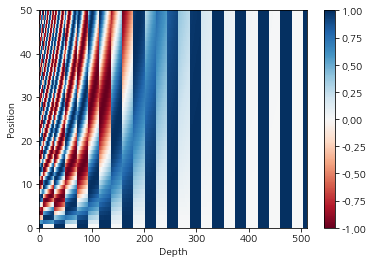

In [20]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

##### Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [21]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [22]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [23]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [24]:
def create_combined_mask(tar) :
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(padding_mask, look_ahead_mask)
    return combined_mask

#### Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [25]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [26]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [27]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [28]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [29]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [30]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


#### Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [31]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [32]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

#### Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [33]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [34]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

#### Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

##### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [35]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2, _

In [36]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output, _ = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

##### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [37]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           combined_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, combined_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
 
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
 
    return out3, attn_weights_block1, attn_weights_block2

In [38]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

#### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [39]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
#    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x, _ = self.enc_layers[i](x, training, mask)
      attention_weights['encoder_layer{}_block'.format(i+1)] = _
        
    return x, attention_weights  # (batch_size, input_seq_len, d_model)

In [40]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output, _ = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


#### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [41]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           combined_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
 #   x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             combined_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [42]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              combined_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

#### Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [43]:
## Implementation of Transformer
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)


  def call(self, inputs, training):
    inp, tar = inputs['inputs']

    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)
    combined_mask = create_combined_mask(tar)

    # (batch_size, inp_seq_len, d_model)
    enc_output, atten = self.encoder(inp, training, enc_padding_mask)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, _= self.decoder(tar, enc_output, training, combined_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    self.encAttention = atten
    self.decAttention = _
    return final_output
    
  def get_decAtten(self) :
    return self.decAttention

  def get_encAtten(self) :
        return self.encAttention

In [44]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out = sample_transformer({'inputs' : (temp_input, temp_target)}, training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

#### Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [45]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

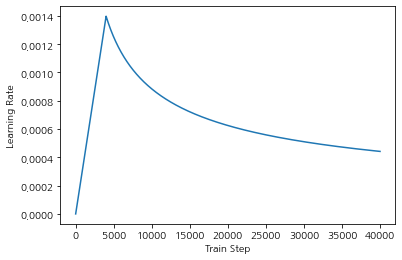

In [46]:
temp_learning_rate_schedule = CustomSchedule(d_model=128)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [47]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [48]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))
  
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [49]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

#### Set Hyperparameter And Training

transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [50]:
tf.keras.backend.clear_session()

# Hyper-parameters
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = Transformer(
    num_layers=NUM_LAYERS, d_model=D_MODEL, num_heads=NUM_HEADS, dff=DFF, 
    input_vocab_size=VOCAB_SIZE, target_vocab_size=VOCAB_SIZE, 
    pe_input=VOCAB_SIZE, pe_target=VOCAB_SIZE, rate=DROPOUT)

In [51]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS)

Epoch 1/20
1563/1563 [==============================] - 340s 217ms/step - loss: 6.0772 - accuracy: 0.0868
Epoch 2/20
1563/1563 [==============================] - 350s 224ms/step - loss: 4.0937 - accuracy: 0.1400
Epoch 3/20
1563/1563 [==============================] - 350s 224ms/step - loss: 3.5681 - accuracy: 0.1605
Epoch 4/20
1563/1563 [==============================] - 344s 220ms/step - loss: 3.1404 - accuracy: 0.1780
Epoch 5/20
1563/1563 [==============================] - 292s 187ms/step - loss: 2.7916 - accuracy: 0.1939
Epoch 6/20
1563/1563 [==============================] - 293s 187ms/step - loss: 2.5188 - accuracy: 0.2076
Epoch 7/20
1563/1563 [==============================] - 294s 188ms/step - loss: 2.3170 - accuracy: 0.2199
Epoch 8/20
1563/1563 [==============================] - 294s 188ms/step - loss: 2.1741 - accuracy: 0.2304
Epoch 9/20
1563/1563 [==============================] - 293s 188ms/step - loss: 2.0348 - accuracy: 0.2399
Epoch 10/20
1563/1563 [=======================

## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the Portuguese tokenizer (`tokenizer_pt`). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == tokenizer_en.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [53]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [54]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer_ko.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):

    predictions = model({'inputs':(sentence, output)}, training = False)
    
    attention_weights = {}
    encAttention_weights = model.get_encAtten()
    decAttention_weights = model.get_decAtten()
    attention_weights.update(encAttention_weights)
    attention_weights.update(decAttention_weights)
    

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [55]:
plt.rc('font', family='NanumGothic')
def plot_attention_weights(attention, sentence, result, plot, layer, block):
  fig = plt.figure(figsize=(25, 25))

  sentence = tokenizer_ko.encode(sentence)

  attention_name = f'{plot}coder_layer{layer}_block{block}'
  attention = tf.squeeze(attention[attention_name], axis=0)

  max_value = 0
  for head in range(attention.shape[0]):
    temp_value = tf.reduce_max(attention[head][:-1]).numpy()
    if max_value < temp_value:
        max_value = temp_value

  for head in range(attention.shape[0]):
    ax = fig.add_subplot(1,8, head+1)

    # plot the attention weights
    ax.matshow(attention[head][:-1, :], vmax = max_value, cmap='viridis')
    
    fontdict = {'fontsize': 10}
    
    if plot=='de' and block=='2':
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_ko.decode([i]) for i in sentence]+['<end>'],
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result
                            if i < tokenizer_en.vocab_size],
                           fontdict=fontdict)
        
    if plot=='de' and block=='1':
        ax.set_xticks(range(len(result)))
        ax.set_yticks(range(len(result)))
        
        ax.set_xlim(-0.5,len(result)-1.5)
        ax.set_ylim(len(result)-1.5,-0.5)

        ax.set_xticklabels([tokenizer_en.decode([i]) for i in result
                            if i < tokenizer_en.vocab_size],
                           fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result
                            if i < tokenizer_en.vocab_size],
                           fontdict=fontdict)
        
    if plot=='en':
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(sentence)+2))
        
        ax.set_ylim(len(sentence)+0.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_ko.decode([i]) for i in sentence]+['<end>'],
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels(
            ['<start>']+[tokenizer_ko.decode([i]) for i in sentence],
            fontdict=fontdict)

    ax.set_xlabel(f'Head {head+1}')

  plt.tight_layout()

  plt.show()


In [56]:
def translate(sentence, plot='', layer = '', block=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot : 
    plot_attention_weights(attention_weights, sentence, result, plot, layer, block)

Input: 그것은 너무 넓었기 때문에 그 동물은 거리를 건너지 못했습니다.
Predicted translation: The animal didn't cross the street because it was too loud .


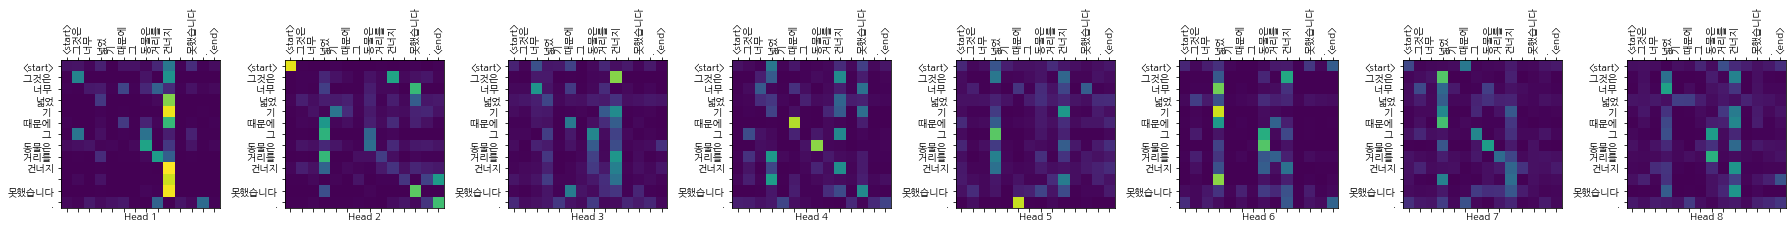

Input: 그것은 너무 넓었기 때문에 그 동물은 거리를 건너지 못했습니다.
Predicted translation: The animal didn't cross the street because it was too loud .


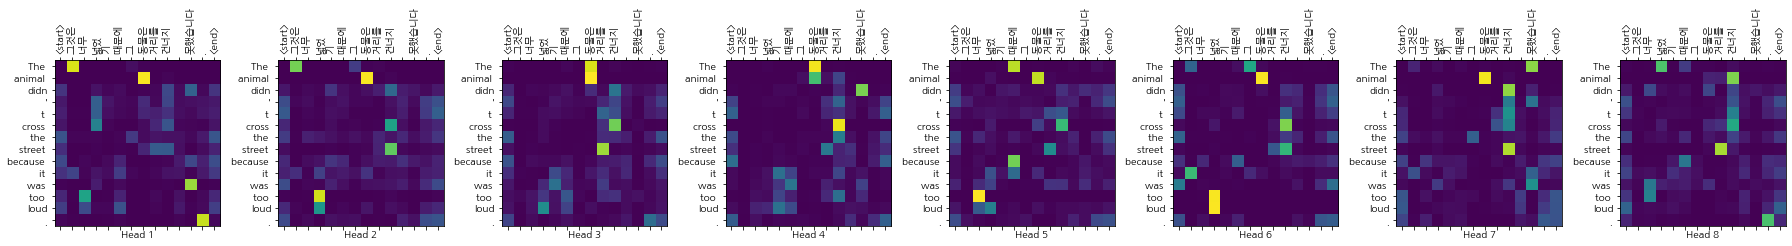

In [57]:
translate("그것은 너무 넓었기 때문에 그 동물은 거리를 건너지 못했습니다.", plot = "en", layer = '2')
translate("그것은 너무 넓었기 때문에 그 동물은 거리를 건너지 못했습니다.", plot = "de", layer = '2', block = '2')

Input: 그것은 너무 피곤했기 때문에 그 동물은 거리를 건너지 못했습니다.
Predicted translation: The animal didn't cross the street because it was too tired .


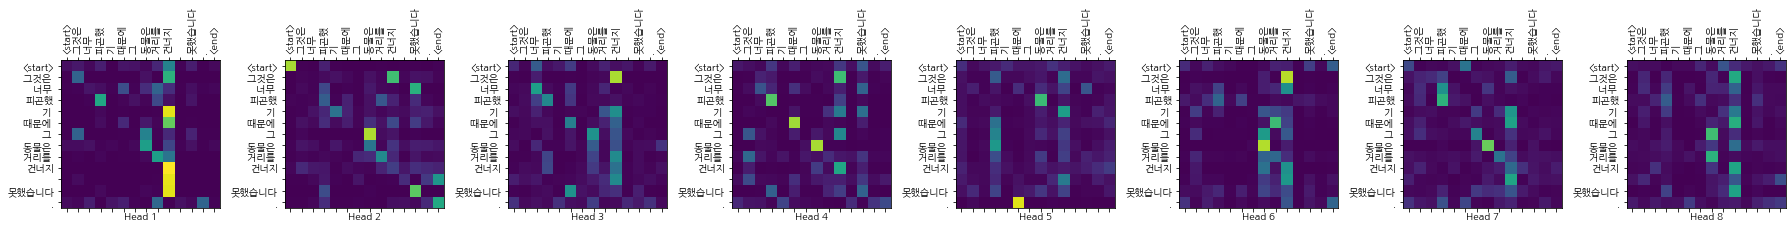

Input: 그것은 너무 피곤했기 때문에 그 동물은 거리를 건너지 못했습니다.
Predicted translation: The animal didn't cross the street because it was too tired .


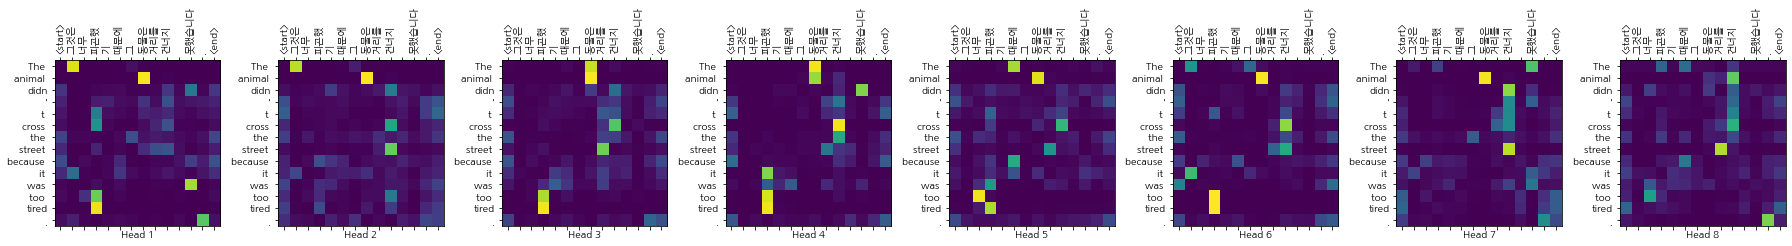

In [58]:
translate("그것은 너무 피곤했기 때문에 그 동물은 거리를 건너지 못했습니다.", plot = "en", layer = '2')
translate("그것은 너무 피곤했기 때문에 그 동물은 거리를 건너지 못했습니다.", plot = "de", layer = '2', block = '2')

Input: 음식이 맛있어보여서 나는 그것을 먹어버렸습니다
Predicted translation: I ate it because the food was delicious ,  but the food tastes delicious .


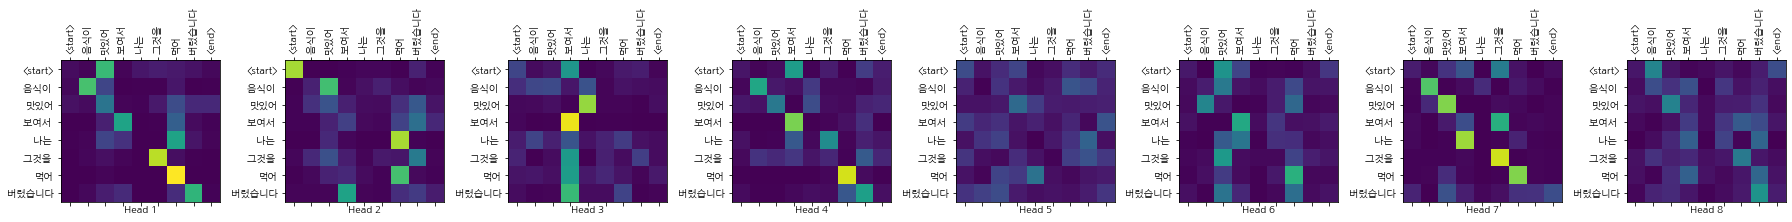

Input: 음식이 맛있어보여서 나는 그것을 먹어버렸습니다
Predicted translation: I ate it because the food was delicious ,  but the food tastes delicious .


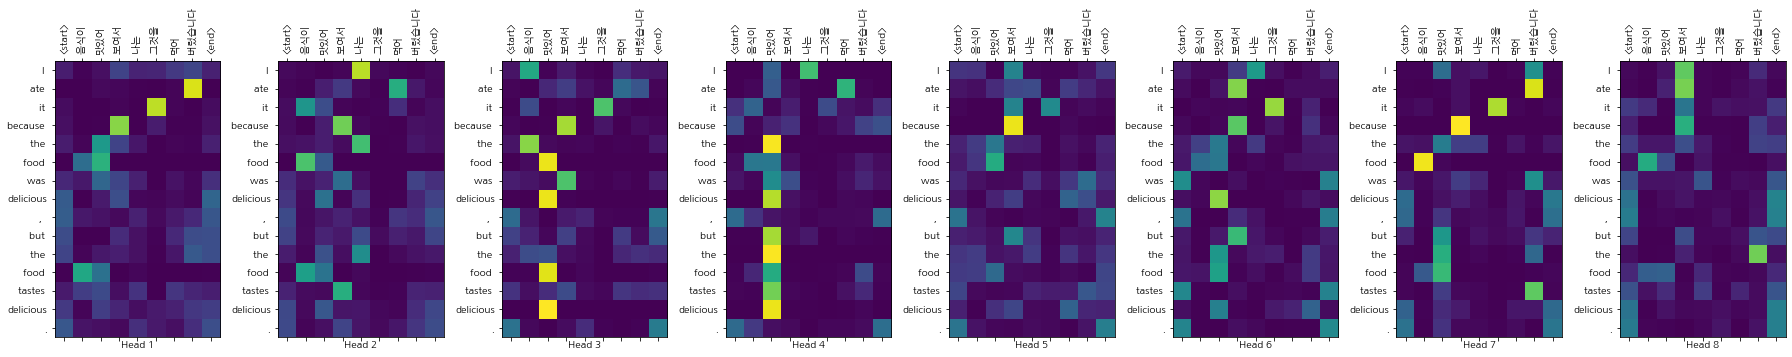

In [59]:
translate("음식이 맛있어보여서 나는 그것을 먹어버렸습니다", plot = "en", layer = '2')
translate("음식이 맛있어보여서 나는 그것을 먹어버렸습니다", plot = "de", layer = '2', block = '2')

Input: 내가 먹을 음식이 바로 이것입니다.
Predicted translation: This is the food I'll eat .


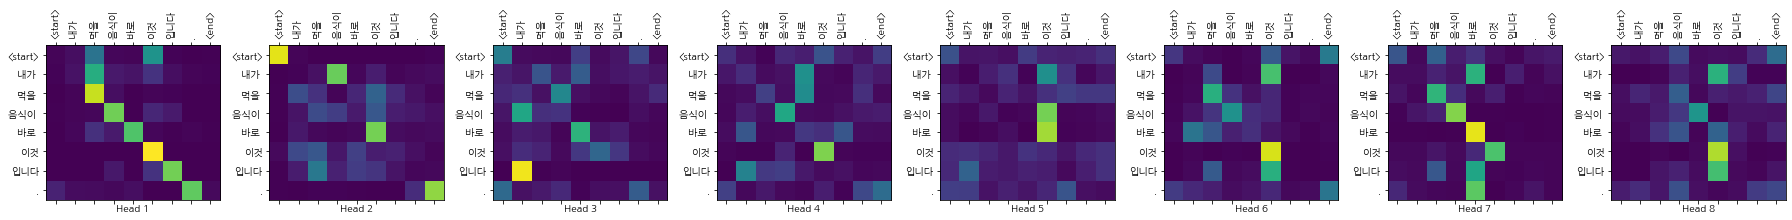

Input: 내가 먹을 음식이 바로 이것입니다.
Predicted translation: This is the food I'll eat .


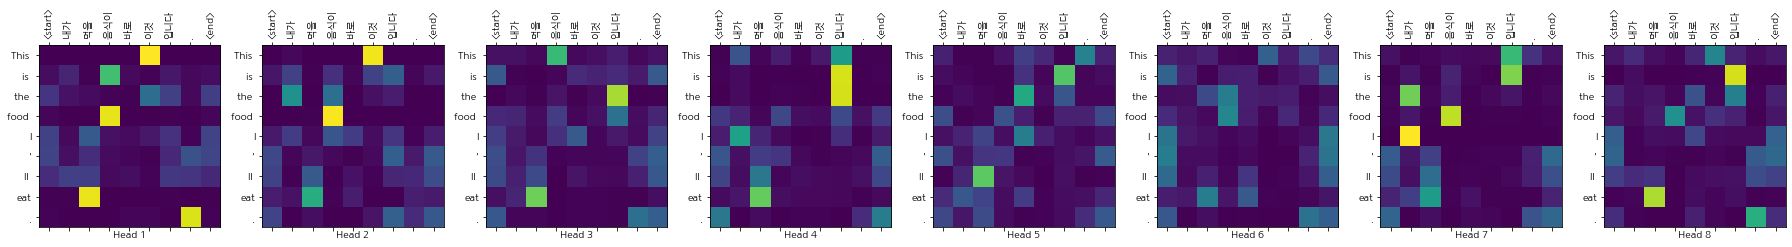

In [60]:
translate("내가 먹을 음식이 바로 이것입니다.", plot = "en", layer = '2')
translate("내가 먹을 음식이 바로 이것입니다.", plot = "de", layer = '2',block = '2')

Input: 그것이 너무 편안해 보여서 나는 침대에 바로 누웠습니다.
Predicted translation: I see it as I'm on bed right away and is very comfortable .


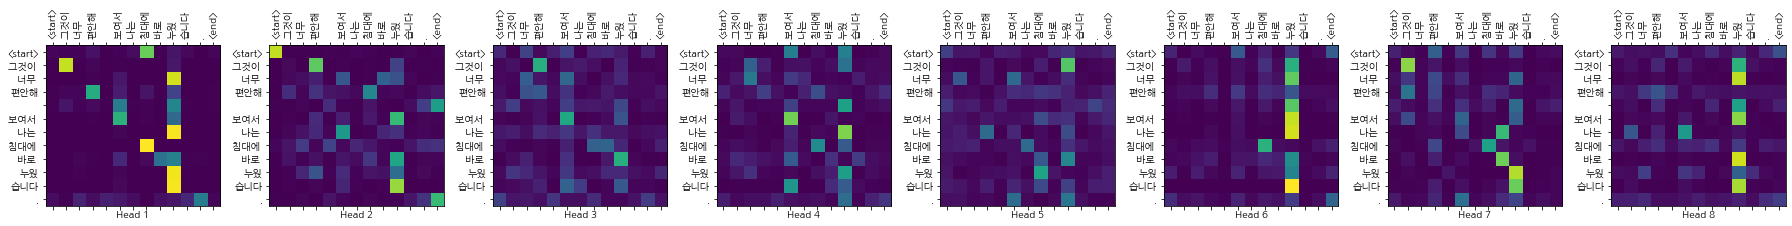

Input: 그것이 너무 편안해 보여서 나는 침대에 바로 누웠습니다.
Predicted translation: I see it as I'm on bed right away and is very comfortable .


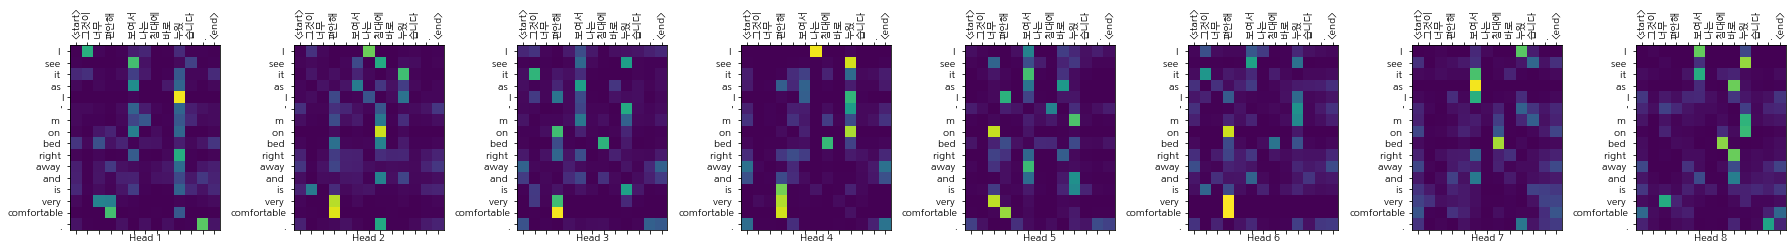

In [61]:
translate("그것이 너무 편안해 보여서 나는 침대에 바로 누웠습니다.", plot = "en", layer = '2')
translate("그것이 너무 편안해 보여서 나는 침대에 바로 누웠습니다.", plot = "de", layer = '2',block = '2')

Input: 나는 재미있는 영화를 원했지만 그것은 지루했다.
Predicted translation: It was a fun but I wanted it with a funny movie .


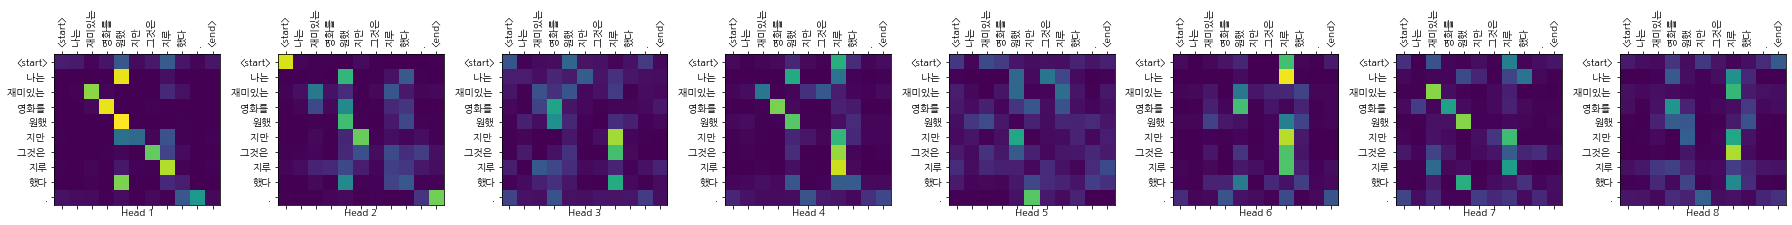

Input: 나는 재미있는 영화를 원했지만 그것은 지루했다.
Predicted translation: It was a fun but I wanted it with a funny movie .


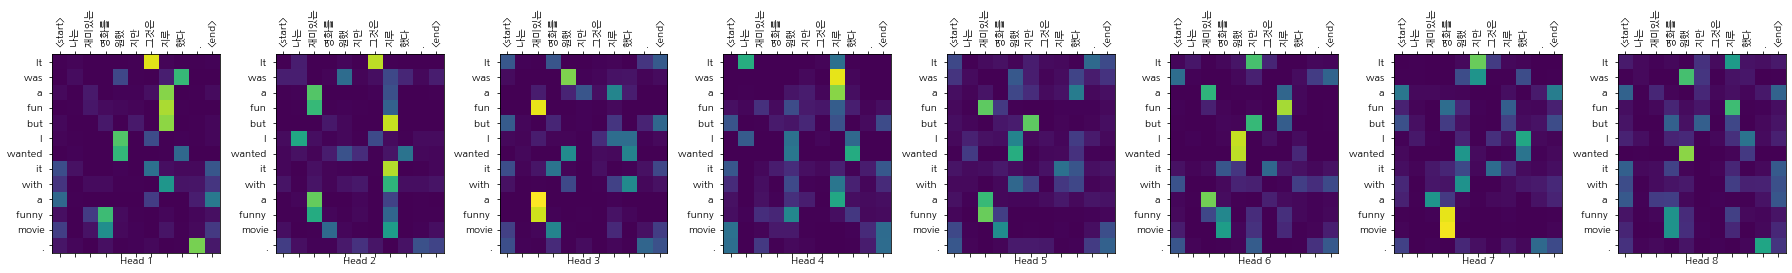

In [62]:
translate("나는 재미있는 영화를 원했지만 그것은 지루했다.", plot = "en", layer = '2')
translate("나는 재미있는 영화를 원했지만 그것은 지루했다.", plot = "de", layer = '2',block = '2')

Input: 그는 이것을 좋아하고 나는 저것을 좋아한다.
Predicted translation: I like this and like that .


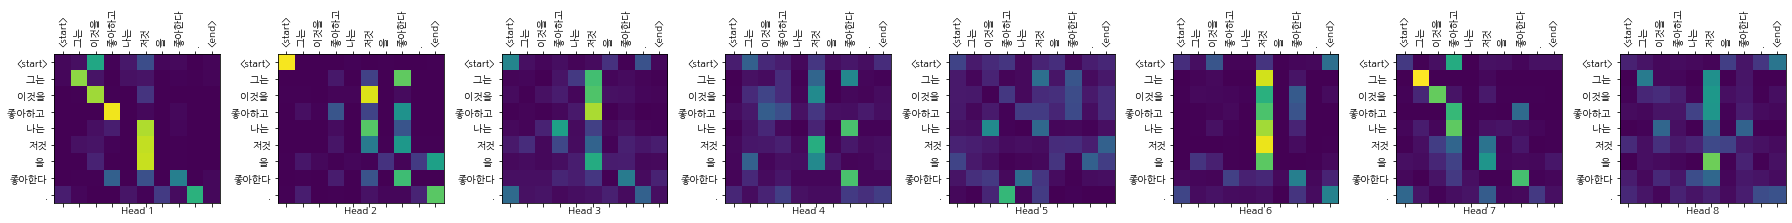

Input: 그는 이것을 좋아하고 나는 저것을 좋아한다.
Predicted translation: I like this and like that .


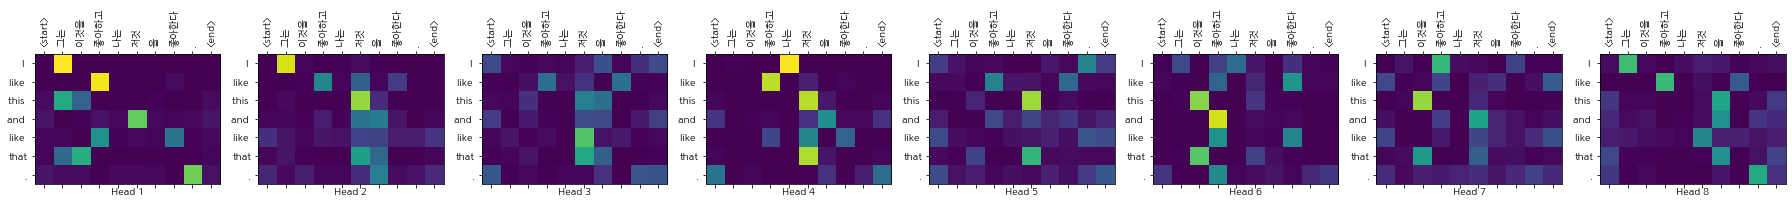

In [63]:
translate("그는 이것을 좋아하고 나는 저것을 좋아한다.", plot = "en", layer = '2')
translate("그는 이것을 좋아하고 나는 저것을 좋아한다.", plot = "de", layer = '2',block = '2')

Input: 그녀는 키가 크지만 나는 작다.
Predicted translation: She is tall but she is tall and I am short .


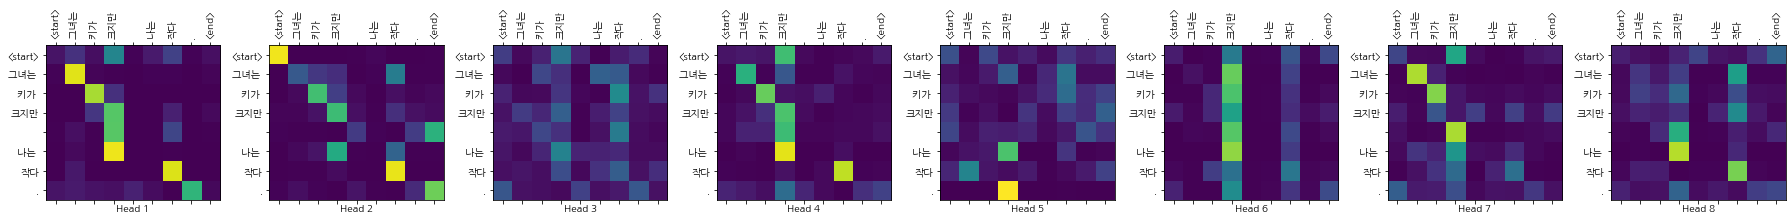

Input: 그녀는 키가 크지만 나는 작다.
Predicted translation: She is tall but she is tall and I am short .


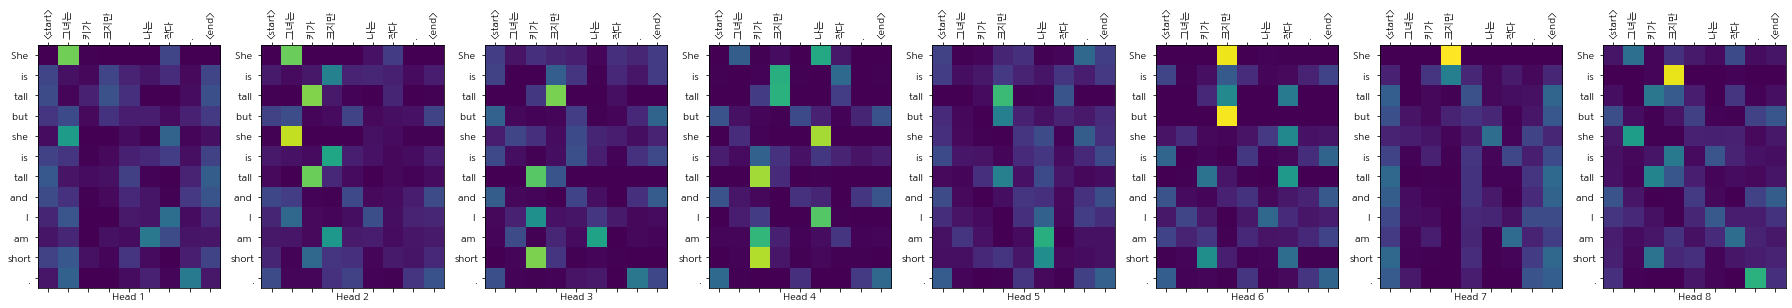

In [64]:
translate("그녀는 키가 크지만 나는 작다.", plot = "en", layer = '2')
translate("그녀는 키가 크지만 나는 작다.", plot = "de", layer = '2',block = '2')

Input: 첫번째 영화는 재미있었지만 두번째 만화는 지루했다.
Predicted translation: It was a fun movie but the first thing I felt boring .


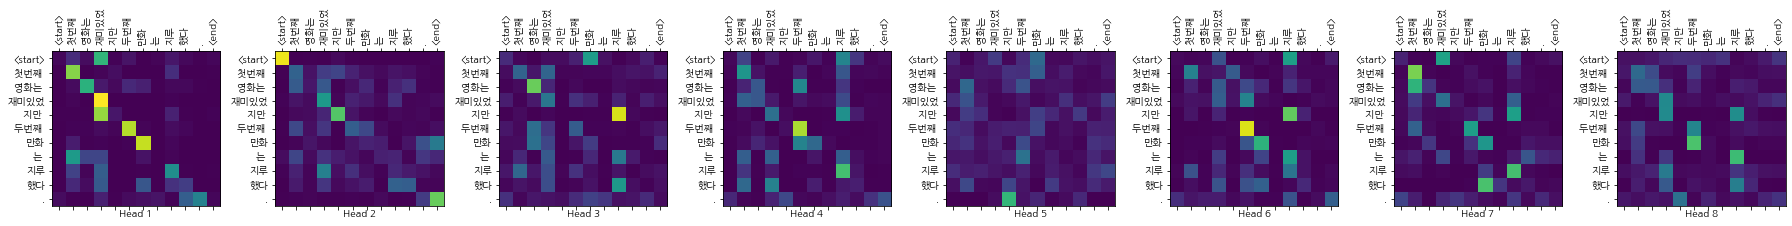

Input: 첫번째 영화는 재미있었지만 두번째 만화는 지루했다.
Predicted translation: It was a fun movie but the first thing I felt boring .


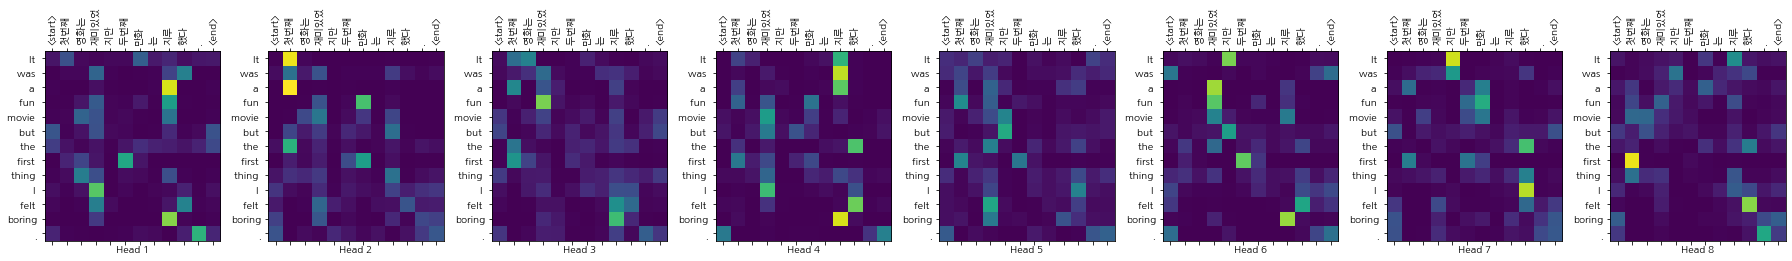

In [65]:
translate("첫번째 영화는 재미있었지만 두번째 만화는 지루했다.", plot = "en", layer = '2')
translate("첫번째 영화는 재미있었지만 두번째 만화는 지루했다.", plot = "de", layer = '2',block = '2')

Input: 나는 그가 좋지만 반면에 나는 그녀가 싫다.
Predicted translation: I like the other hand ,  but I hate her because she doesn't like it .


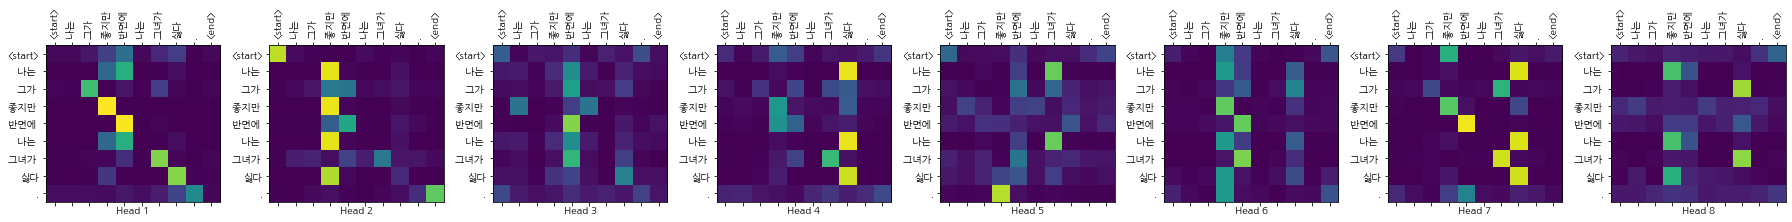

Input: 나는 그가 좋지만 반면에 나는 그녀가 싫다.
Predicted translation: I like the other hand ,  but I hate her because she doesn't like it .


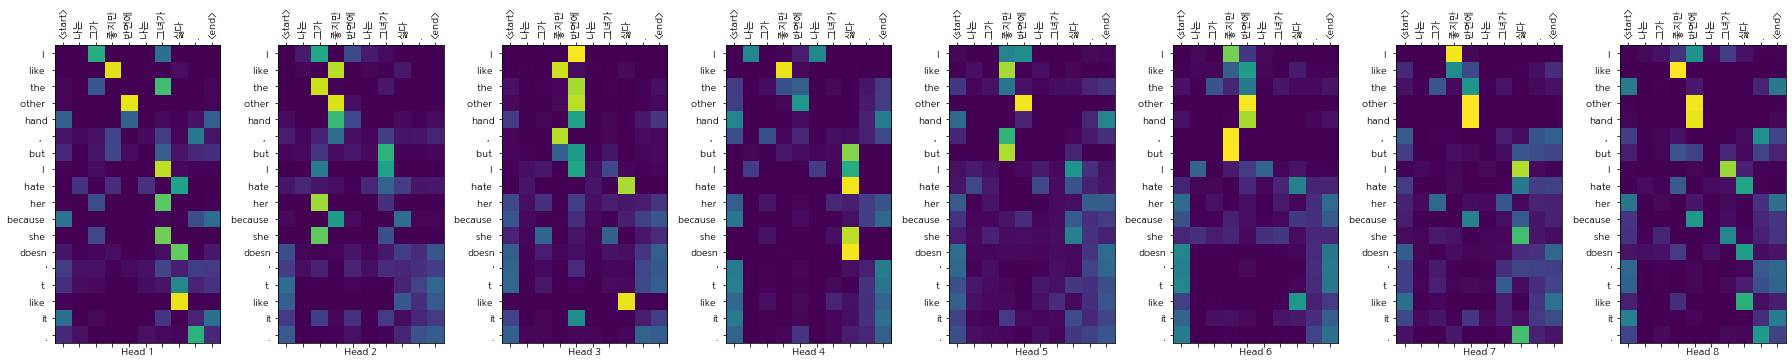

In [66]:
translate("나는 그가 좋지만 반면에 나는 그녀가 싫다.", plot = "en", layer = '2')
translate("나는 그가 좋지만 반면에 나는 그녀가 싫다.", plot = "de", layer = '2',block = '2')

Input: 그가 화났으니까 내가 너 대신 통화해 볼게.
Predicted translation: I'll talk about you ,  so I'll go to work on a phone instead of you .


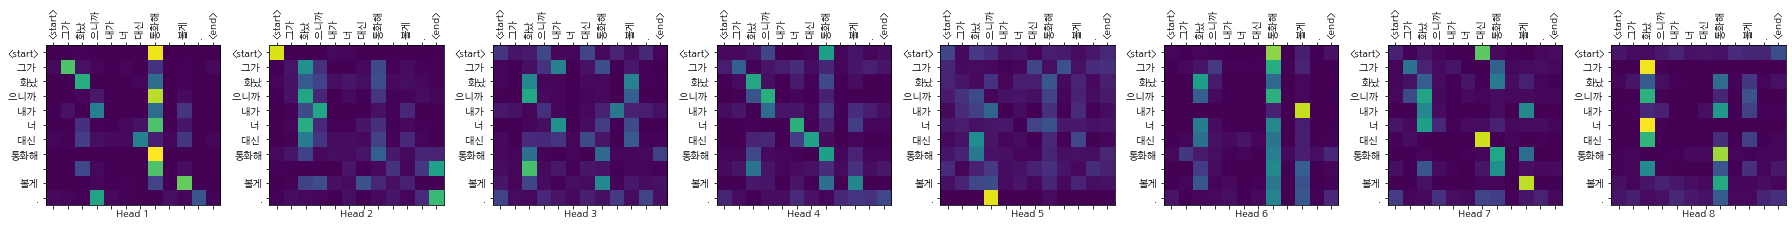

Input: 그가 화났으니까 내가 너 대신 통화해 볼게.
Predicted translation: I'll talk about you ,  so I'll go to work on a phone instead of you .


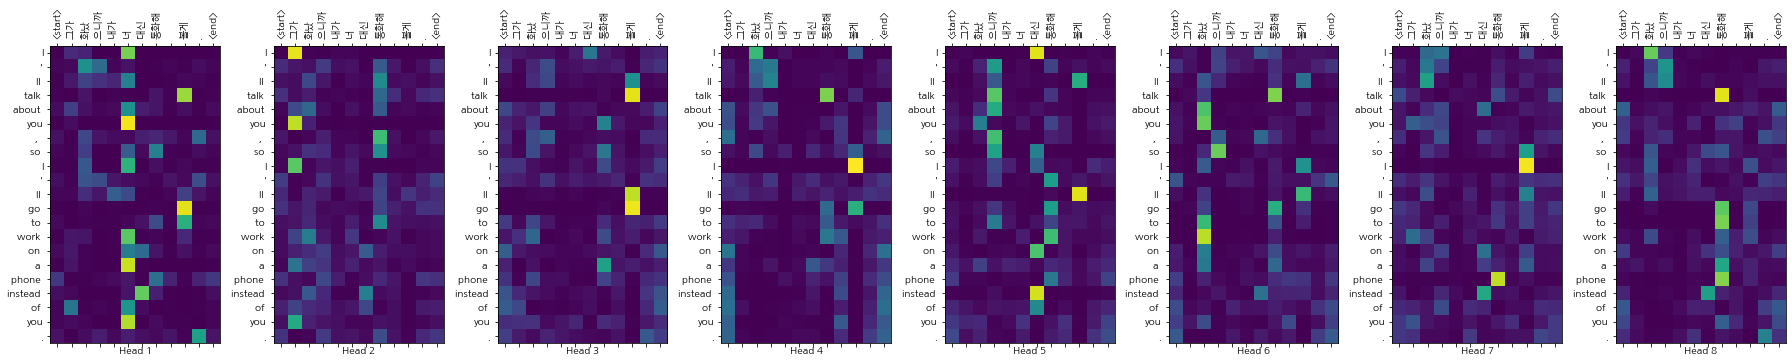

In [67]:
translate("그가 화났으니까 내가 너 대신 통화해 볼게.", plot = "en", layer = '2')
translate("그가 화났으니까 내가 너 대신 통화해 볼게.", plot = "de", layer = '2',block = '2')

Input: 그는 나에게 전부이지만 그에게 나는 아무것도 아닙니다.
Predicted translation: He doesn't have anything to me ,  but he joined my  ?


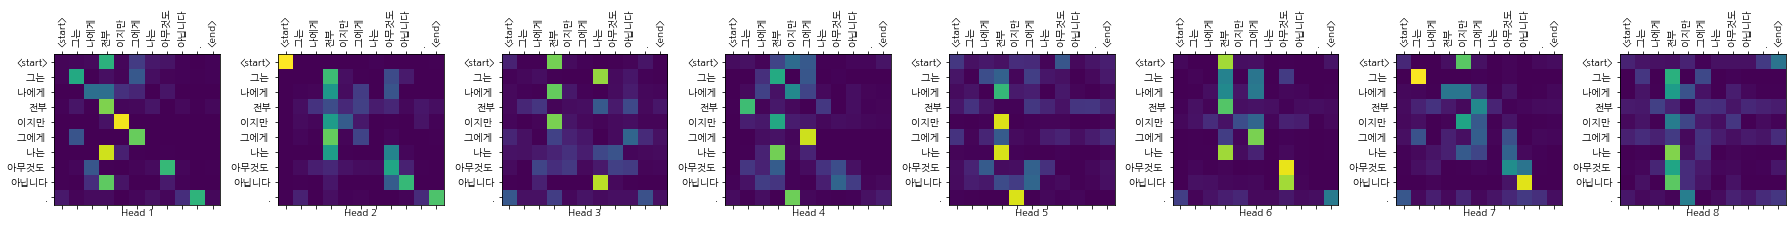

Input: 그는 나에게 전부이지만 그에게 나는 아무것도 아닙니다.
Predicted translation: He doesn't have anything to me ,  but he joined my  ?


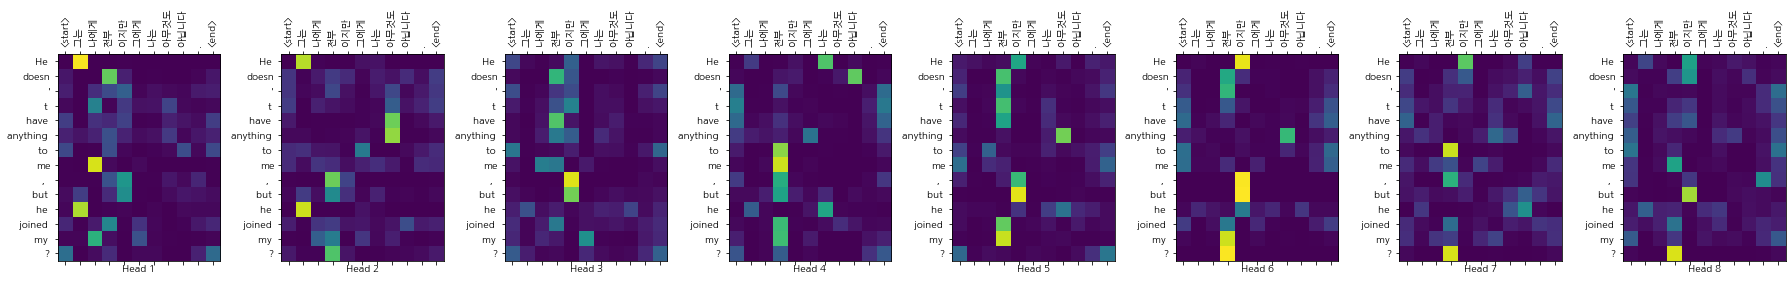

In [68]:
translate("그는 나에게 전부이지만 그에게 나는 아무것도 아닙니다.", plot = "en", layer = '2')
translate("그는 나에게 전부이지만 그에게 나는 아무것도 아닙니다.", plot = "de", layer = '2',block = '2')

Input: 내가 먼저 가고 너는 나중에 가.
Predicted translation: You go first and go there later .


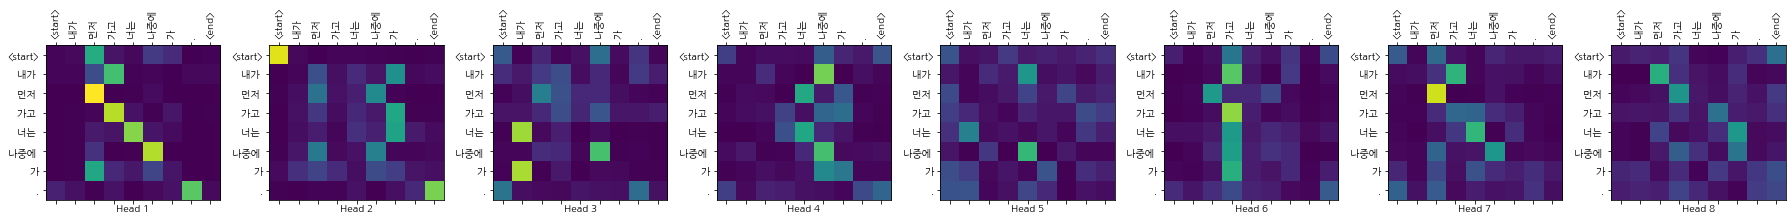

Input: 내가 먼저 가고 너는 나중에 가.
Predicted translation: You go first and go there later .


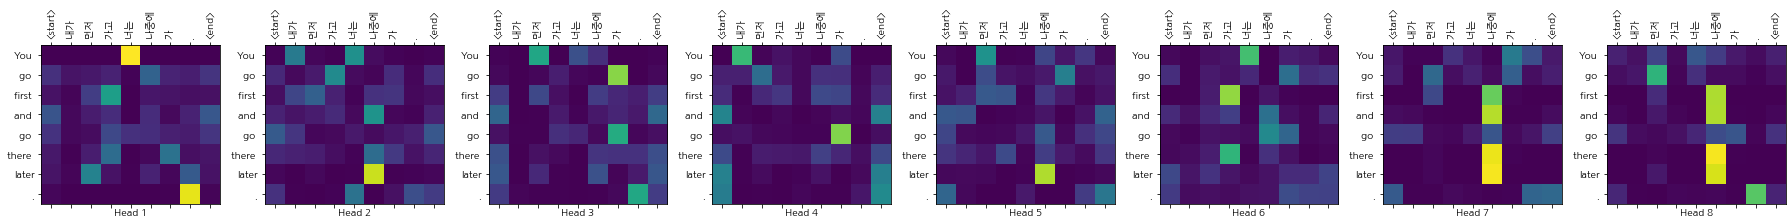

In [69]:
translate("내가 먼저 가고 너는 나중에 가.", plot = "en", layer = '2')
translate("내가 먼저 가고 너는 나중에 가.", plot = "de", layer = '2',block = '2')

Input: 그 말이 정말 진실이라는 것에 나는 놀랐다.
Predicted translation: What I said at that is true ,  I was so true .


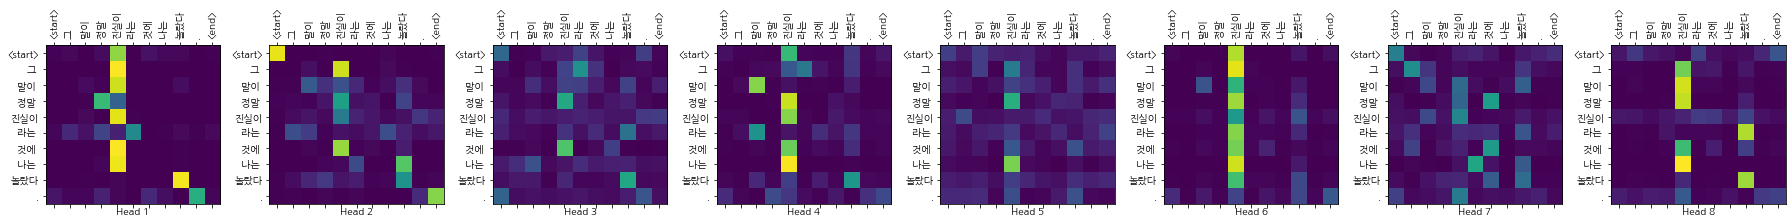

Input: 그 말이 정말 진실이라는 것에 나는 놀랐다.
Predicted translation: What I said at that is true ,  I was so true .


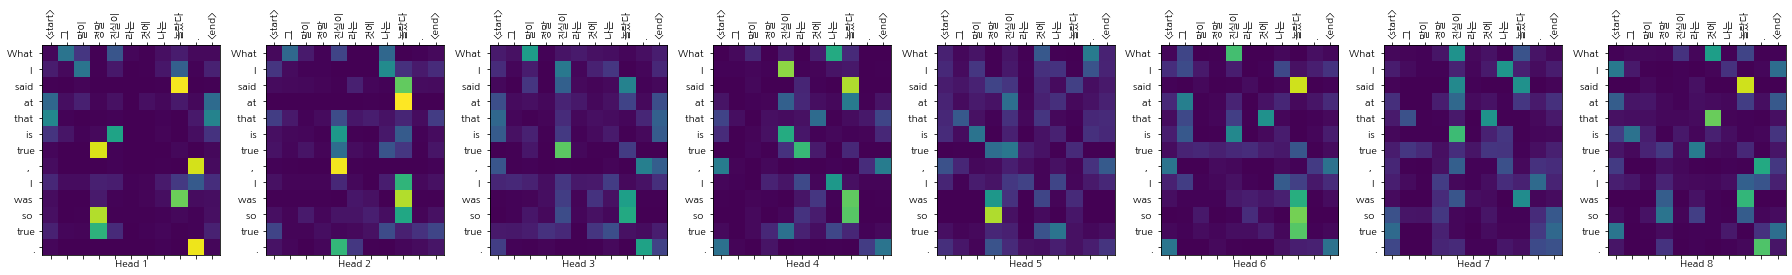

In [70]:
translate("그 말이 정말 진실이라는 것에 나는 놀랐다.", plot = "en", layer = '2')
translate("그 말이 정말 진실이라는 것에 나는 놀랐다.", plot = "de", layer = '2',block = '2')

Input: 저는 빨강은 좋지만 검정색은 싫어합니다.
Predicted translation: I like black colors ,  but I hate black .


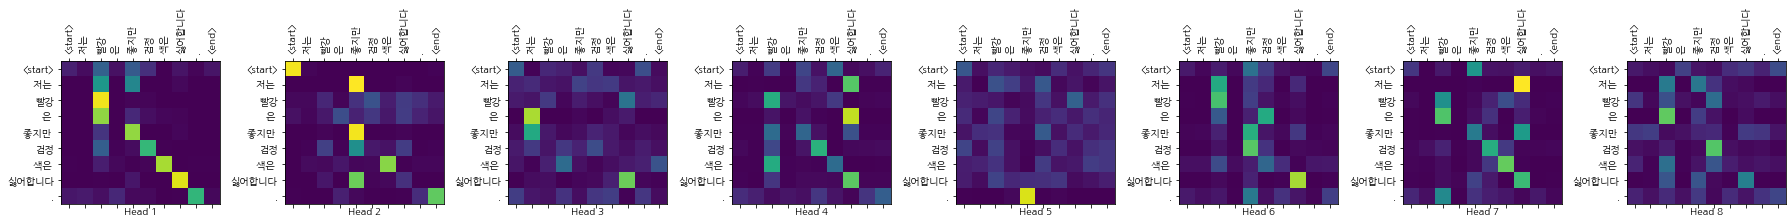

Input: 저는 빨강은 좋지만 검정색은 싫어합니다.
Predicted translation: I like black colors ,  but I hate black .


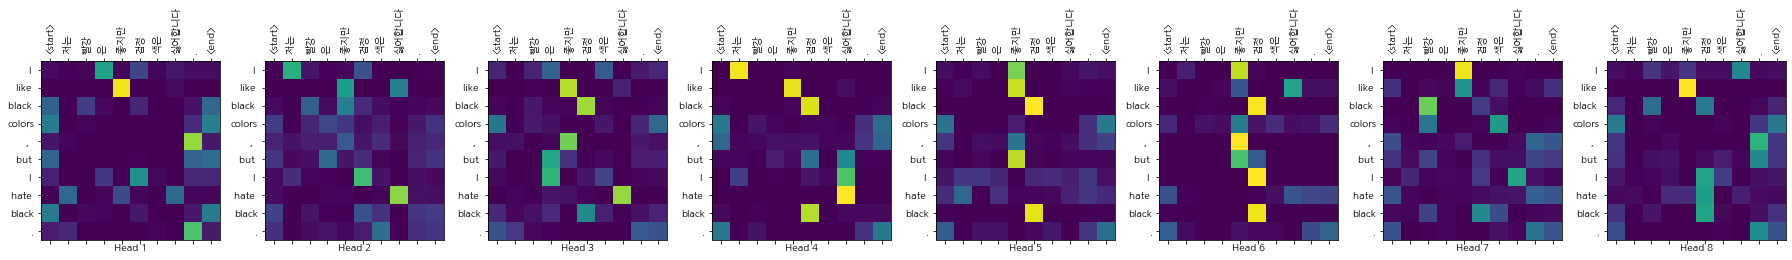

In [71]:
translate("저는 빨강은 좋지만 검정색은 싫어합니다.", plot = "en", layer = '2')
translate("저는 빨강은 좋지만 검정색은 싫어합니다.", plot = "de", layer = '2',block = '2')

## Summary

In this tutorial, you learned about positional encoding, multi-head attention, the importance of masking and how to create a transformer.

Try using a different dataset to train the transformer. You can also create the base transformer or transformer XL by changing the hyperparameters above. You can also use the layers defined here to create [BERT](https://arxiv.org/abs/1810.04805) and train state of the art models. Futhermore, you can implement beam search to get better predictions.

##### Return Resource

In [1]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [2]:
!nvidia-smi


Sun Feb 14 16:58:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   46C    P0    40W / 300W |     12MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   45C    P0    43W / 300W |     12MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T